# Stock Market Prediction using Numerical and Textual Analysis

Creating a hybrid model for stock price/performance prediction using 
numerical analysis of historical stock prices, and sentimental analysis of news headlines.



In [2]:
!pip install yahoo_finance_api2
!pip install yfinance
!pip install textblob

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import scipy.stats as stats

### Importing the Stock Dataset

In [3]:
stock='^BSESN'
data = yf.download(stock, start="2014-10-09", end="2020-10-09")
data.to_csv('stock.csv')

[*********************100%***********************]  1 of 1 completed


In [31]:
stocks = pd.read_csv('stock.csv')
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-09,26394.369141,26688.699219,26394.210938,26637.279297,26637.279297,7500
1,2014-10-10,26551.740234,26555.919922,26261.609375,26297.380859,26297.380859,9200
2,2014-10-13,26275.070312,26443.160156,26092.689453,26384.070312,26384.070312,6400
3,2014-10-14,26537.419922,26550.789062,26212.009766,26349.330078,26349.330078,11900
4,2014-10-16,26260.349609,26462.080078,25933.980469,25999.339844,25999.339844,10700


In [32]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 7 columns):
Date         1469 non-null object
Open         1469 non-null float64
High         1469 non-null float64
Low          1469 non-null float64
Close        1469 non-null float64
Adj Close    1469 non-null float64
Volume       1469 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 80.4+ KB


In [33]:
stocks.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1469.000000,1469.000000,1469.000000,1469.000000,1469.000000,1.469000e+03
mean,32168.413947,32318.589011,31942.597602,32121.314179,32121.314179,2.306365e+05
std,4997.984204,5007.445278,4970.163895,4986.243526,4986.243526,1.944855e+06
min,23060.390625,23142.960938,22494.609375,22951.830078,22951.830078,2.500000e+03
25%,27760.109375,27911.439453,27598.210938,27730.210938,27730.210938,1.000000e+04
50%,31775.539062,31937.509766,31598.000000,31715.640625,31715.640625,1.280000e+04
75%,36449.269531,36616.640625,36216.949219,36395.031250,36395.031250,1.820000e+04
max,42263.000000,42273.871094,41850.289062,41952.628906,41952.628906,3.181510e+07


### Data Pre-processing and EDA of News Dataset

In [34]:
stocks['HL_pct']=((stocks['High']-stocks['Low'])/stocks['Low'])*100
stocks['PCT_change']=((stocks['Close']-stocks['Open'])/stocks['Open'])*100
stocks = stocks.drop(['Open','High','Close','Low'], axis=1)
stocks.head()

,Date,Adj Close,Volume,HL_pct,PCT_change
0,2014-10-09,26637.279297,7500,1.115731,0.920311
1,2014-10-10,26297.380859,9200,1.120687,-0.957976
2,2014-10-13,26384.070312,6400,1.343176,0.414842
3,2014-10-14,26349.330078,11900,1.292458,-0.708772
4,2014-10-16,25999.339844,10700,2.036323,-0.993931


In [63]:
news= pd.read_csv("india-news-headlines.csv",date)
news.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [36]:
news['published_date'] = np.array([str(str(str(x)[:4]) + '/' + str(str(x)[4:6]) + '/' + str(str(x)[6:])) for x in news['publish_date']])

In [37]:
news.head()

,publish_date,headline_category,headline_text,published_date
0,20010101,sports.wwe,win over cena satisfying but defeating underta...,2001/01/01
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,2001/01/02
2,20010102,unknown,Fissures in Hurriyat over Pak visit,2001/01/02
3,20010102,unknown,America's unwanted heading for India?,2001/01/02
4,20010102,unknown,For bigwigs; it is destination Goa,2001/01/02


In [38]:
news = news.drop('publish_date', axis=1)
news.head()


,headline_category,headline_text,published_date
0,sports.wwe,win over cena satisfying but defeating underta...,2001/01/01
1,unknown,Status quo will not be disturbed at Ayodhya; s...,2001/01/02
2,unknown,Fissures in Hurriyat over Pak visit,2001/01/02
3,unknown,America's unwanted heading for India?,2001/01/02
4,unknown,For bigwigs; it is destination Goa,2001/01/02


In [39]:
news['published_date'] = pd.to_datetime(news['published_date'])
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
headline_category    object
headline_text        object
published_date       datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 75.5+ MB


In [40]:
news = news[['published_date', 'headline_text']]
news.columns = ['published_date', 'headline']
news.head()

,published_date,headline
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa


### Accumulating headlines having same dates

In [41]:
dict_news = {}
temp = news.loc[0, 'published_date']
temp2 = str(news.loc[0, 'headline'])
for x in range(1, len(news)):
    if news.loc[x, 'published_date']==temp:
        temp2 += '. ' + str(news.loc[x, 'headline'])
    else:
        dict_news[news.loc[x-1, 'published_date']] = temp2
        temp2 = ""
        temp = news.loc[x, 'published_date']

In [43]:
len(dict_news)

7079

In [44]:
indexes = np.arange(0, len(dict_news))
df_news = pd.DataFrame(indexes)
df_news.head()

,0
0,0
1,1
2,2
3,3
4,4


In [45]:
df_news['Published_Date'] = dict_news.keys()
df_news.head()

,0,Published_Date
0,0,2001-01-01
1,1,2001-01-02
2,2,2001-01-03
3,3,2001-01-04
4,4,2001-01-05


In [46]:
li = []
for i in dict_news.keys():
    li.append(dict_news[i])
    
li[0]

'win over cena satisfying but defeating undertaker bigger roman reigns'

In [47]:
df_news['Headline'] = np.array(li)
df_news.head()

,0,Published_Date,Headline
0,0,2001-01-01,win over cena satisfying but defeating underta...
1,1,2001-01-02,. Fissures in Hurriyat over Pak visit. America...
2,2,2001-01-03,. Think again; Laxman tells Sangh Parivar. Hur...
3,3,2001-01-04,. Vajpayee gives big push to tech education; R...
4,4,2001-01-05,. Hawkings' day out. Light combat craft takes ...


In [48]:
df_news = df_news.drop(0, axis=1)

### Performing Sentiment Analysis on News Dataset

In [49]:
polarity = []
subjectivity = []
tuples = []

for i in df_news['Headline'].values:
    my_valence = TextBlob(i)
    tuples.append(my_valence.sentiment)
    
for i in tuples:
    polarity.append(i[0])
    subjectivity.append(i[1])

In [50]:
df_news['Polarity'] = np.array(polarity)
df_news['Subjectivity'] = np.array(subjectivity)

df_news.head()

,Published_Date,Headline,Polarity,Subjectivity
0,2001-01-01,win over cena satisfying but defeating underta...,0.433333,0.633333
1,2001-01-02,. Fissures in Hurriyat over Pak visit. America...,0.151333,0.282333
2,2001-01-03,. Think again; Laxman tells Sangh Parivar. Hur...,0.163636,0.363636
3,2001-01-04,. Vajpayee gives big push to tech education; R...,0.087961,0.446847
4,2001-01-05,. Hawkings' day out. Light combat craft takes ...,0.260401,0.473984


In [51]:
temp = ['Positive', 'Negative', 'Neutral']
temp1 = ['Factual', 'Public']
polarity = []
subjectivity = []
for i in range(len(df_news)):
    pol = df_news.iloc[i]['Polarity']
    sub = df_news.iloc[i]['Subjectivity']
    if pol>=0:
        if pol>=0.2:
            polarity.append(temp[0])
        else:
            polarity.append(temp[2])
    else:
        if pol<=-0.2:
            polarity.append(temp[1])
        else:
            polarity.append(temp[2])
    
    if sub>=0.4:
        subjectivity.append(temp1[1])
    else:
        subjectivity.append(temp1[0])

df_news['Sentiment'] = polarity
df_news['Opinion'] = subjectivity

In [52]:
df_news.head()

,Published_Date,Headline,Polarity,Subjectivity,Sentiment,Opinion
0,2001-01-01,win over cena satisfying but defeating underta...,0.433333,0.633333,Positive,Public
1,2001-01-02,. Fissures in Hurriyat over Pak visit. America...,0.151333,0.282333,Neutral,Factual
2,2001-01-03,. Think again; Laxman tells Sangh Parivar. Hur...,0.163636,0.363636,Neutral,Factual
3,2001-01-04,. Vajpayee gives big push to tech education; R...,0.087961,0.446847,Neutral,Public
4,2001-01-05,. Hawkings' day out. Light combat craft takes ...,0.260401,0.473984,Positive,Public


In [53]:
len(df_news)

7079

### Distribution of Sentiments and Opinions

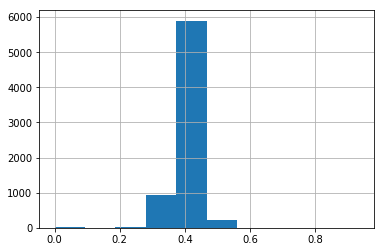

In [54]:
df_news['Subjectivity'].hist()
plt.show()

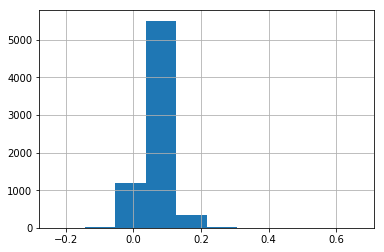

In [55]:
df_news['Polarity'].hist()
plt.show()

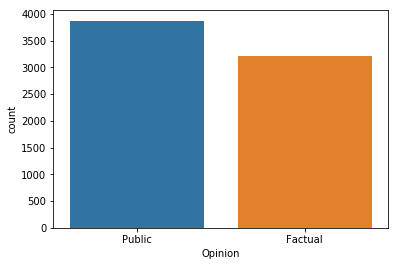

In [56]:
sns.countplot(df_news['Opinion'])

In [57]:
df_news.columns = ['Date', 'Headline', 'Polarity', 'Subjectivity', 'Sentiment', 'Opinion']

### Merging the News and Stocks Datasets on the basis of Dates

In [70]:
stocks['Date'] = pd.to_datetime(stocks['Date'])
merge_data = df_news.merge(stocks, how='inner', on='Date', left_index = True)
merge_data.head()

,Date,Headline,Polarity,Subjectivity,Sentiment,Opinion,Adj Close,Volume,HL_pct,PCT_change
0,2014-10-09,. Jobs for those who don't like interacting. H...,0.093478,0.428911,Neutral,Public,26637.279297,7500,1.115731,0.920311
1,2014-10-10,. Don't turn tablets into toys for kids. How f...,0.065687,0.420088,Neutral,Public,26297.380859,9200,1.120687,-0.957976
2,2014-10-13,. How to reveal your feelings to the guy you l...,0.073393,0.414125,Neutral,Public,26384.070312,6400,1.343176,0.414842
3,2014-10-14,. The emotional intelligence advantage. Learn ...,0.087402,0.414189,Neutral,Public,26349.330078,11900,1.292458,-0.708772
4,2014-10-16,. Recipe: Stuffed cobra rice roll. How to mana...,0.068723,0.396495,Neutral,Factual,25999.339844,10700,2.036323,-0.993931


In [71]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1397 entries, 0 to 1396
Data columns (total 10 columns):
Date            1397 non-null datetime64[ns]
Headline        1397 non-null object
Polarity        1397 non-null float64
Subjectivity    1397 non-null float64
Sentiment       1397 non-null object
Opinion         1397 non-null object
Adj Close       1397 non-null float64
Volume          1397 non-null int64
HL_pct          1397 non-null float64
PCT_change      1397 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 120.1+ KB


### Required columns of the Merged Dataset

In [72]:
df_needed = merge_data[['Date', 'Polarity', 'Subjectivity','Adj Close','HL_pct','PCT_change']]
df_needed.head()

,Date,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
0,2014-10-09,0.093478,0.428911,26637.279297,1.115731,0.920311
1,2014-10-10,0.065687,0.420088,26297.380859,1.120687,-0.957976
2,2014-10-13,0.073393,0.414125,26384.070312,1.343176,0.414842
3,2014-10-14,0.087402,0.414189,26349.330078,1.292458,-0.708772
4,2014-10-16,0.068723,0.396495,25999.339844,2.036323,-0.993931


In [74]:
df_needed = df_needed.set_index('Date')
df_needed.head()

,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
Date,,,,,
2014-10-09,0.093478,0.428911,26637.279297,1.115731,0.920311
2014-10-10,0.065687,0.420088,26297.380859,1.120687,-0.957976
2014-10-13,0.073393,0.414125,26384.070312,1.343176,0.414842
2014-10-14,0.087402,0.414189,26349.330078,1.292458,-0.708772
2014-10-16,0.068723,0.396495,25999.339844,2.036323,-0.993931


### Using MinMaxScaler to develop a model based on it 

In [91]:
scaler = MinMaxScaler()
new = pd.DataFrame(scaler.fit_transform(df_needed))
new.columns = df_needed.columns
new.index=df_needed.index
new.head()

,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
Date,,,,,
2014-10-09,0.628196,0.690516,0.193963,0.046432,0.480135
2014-10-10,0.477802,0.627213,0.176074,0.046707,0.363001
2014-10-13,0.519500,0.584427,0.180637,0.059047,0.448613
2014-10-14,0.595314,0.584891,0.178808,0.056234,0.378542
2014-10-16,0.494230,0.457936,0.160389,0.097493,0.360759


In [252]:
trainSet = new[: int(0.7*(len(new)))]
testSet = new[int(0.7*(len(new))):]

model = VAR(endog = trainSet)
fit = model.fit()

C:\Users\Anusha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [253]:
trainSet.head()

,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
Date,,,,,
2014-10-09,0.628196,0.690516,0.193963,0.046432,0.480135
2014-10-10,0.477802,0.627213,0.176074,0.046707,0.363001
2014-10-13,0.519500,0.584427,0.180637,0.059047,0.448613
2014-10-14,0.595314,0.584891,0.178808,0.056234,0.378542
2014-10-16,0.494230,0.457936,0.160389,0.097493,0.360759


In [254]:
pred = fit.forecast(fit.y, steps=len(testSet))
predicted = pd.DataFrame(pred,columns = df_needed.columns)

In [255]:
predicted.head()

,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
0,0.419714,0.467933,0.683852,0.049454,0.406868
1,0.411609,0.454217,0.683818,0.035352,0.411982
2,0.407566,0.445268,0.683909,0.031554,0.413045
3,0.405901,0.442160,0.684037,0.030479,0.413330
4,0.405291,0.441180,0.684177,0.030168,0.413415


In [256]:
testSet.head()

,Polarity,Subjectivity,Adj Close,HL_pct,PCT_change
Date,,,,,
2018-10-04,0.306379,0.469504,0.642990,0.110993,0.309342
2018-10-05,0.424176,0.436689,0.601299,0.133146,0.294636
2018-10-08,0.484947,0.251124,0.606424,0.092584,0.433982
2018-10-09,0.585180,0.503767,0.597219,0.062022,0.359331
2018-10-10,0.615309,0.468899,0.621503,0.067205,0.471138


### Checking the accuracy

In [257]:
np.sqrt(mean_squared_error(predicted['Adj Close'], testSet['Adj Close']))

0.1733784982546075

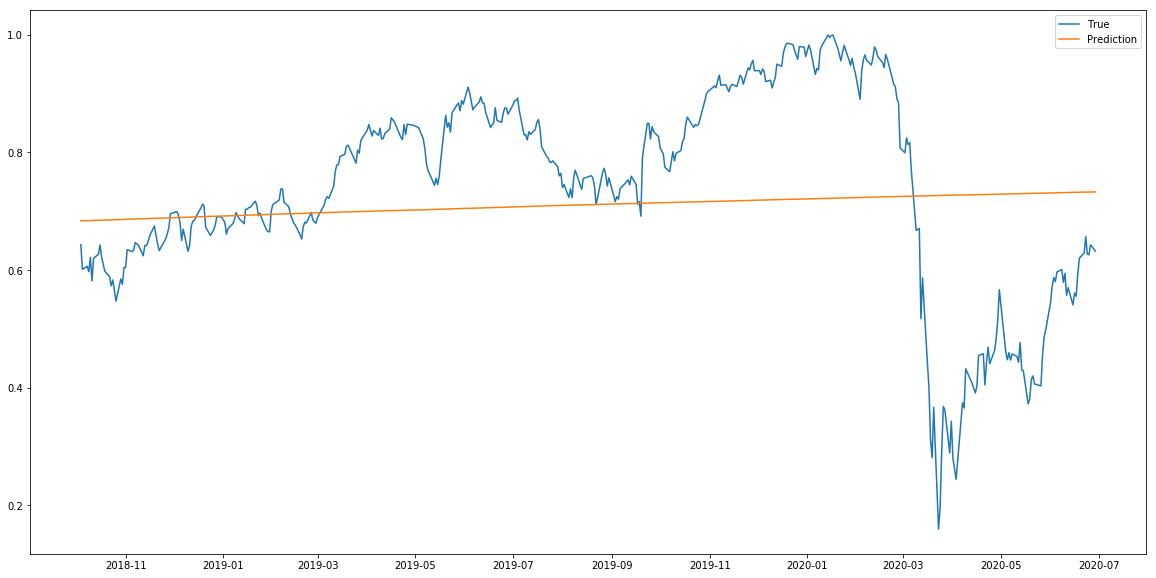

In [287]:
plt.figure(figsize=(20,10))
plt.plot(testSet['Adj Close'],label='True')
plt.plot(testSet.index,predicted['Adj Close'],label='Prediction')
plt.legend()


C:\Users\Anusha\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


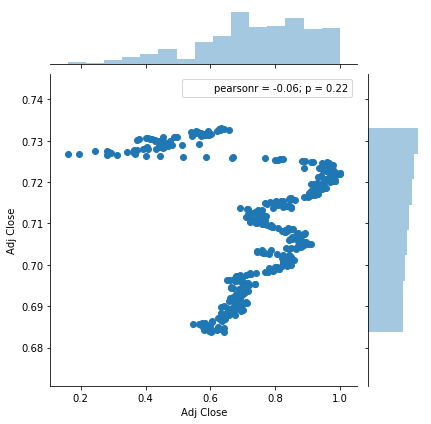

In [288]:
sns.jointplot(testSet['Adj Close'], predicted['Adj Close']).annotate(stats.pearsonr)
plt.show()